In [2]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf

In [3]:
ratings_df = pd.read_csv("data/ratings.csv")
books_df = pd.read_csv("data/books.csv")

In [4]:
print(ratings_df.shape)
print(ratings_df.user_id.nunique())
print(ratings_df.book_id.nunique())
ratings_df.isna().sum()

(981756, 3)
53424
10000


book_id    0
user_id    0
rating     0
dtype: int64

In [5]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest = train_test_split(ratings_df, test_size=0.2, random_state=1)
print(f"Shape of train data: {Xtrain.shape}")
print(f"Shape of test data: {Xtest.shape}")

Shape of train data: (785404, 3)
Shape of test data: (196352, 3)


In [9]:

#Get the number of unique entities in books and users columns
nbook_id = ratings_df.book_id.nunique()
nuser_id = ratings_df.user_id.nunique()


#Book input network
input_books = tf.keras.layers.Input(shape=[1])
embed_books = tf.keras.layers.Embedding(nbook_id + 1,15)(input_books)
books_out = tf.keras.layers.Flatten()(embed_books)

#user input network
input_users = tf.keras.layers.Input(shape=[1])
embed_users = tf.keras.layers.Embedding(nuser_id + 1,15)(input_users)
users_out = tf.keras.layers.Flatten()(embed_users)

conc_layer = tf.keras.layers.Concatenate()([books_out, users_out])
x = tf.keras.layers.Dense(128, activation='relu')(conc_layer)
x_out = x = tf.keras.layers.Dense(1, activation='relu')(x)

model = tf.keras.Model([input_books, input_users], x_out)

opt = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_squared_error')

In [10]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 15)        150015      input_5[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 15)        801375      input_6[0][0]                    
_______________________________________________________________________________________

In [11]:
hist = model.fit([Xtrain.book_id, Xtrain.user_id], Xtrain.rating, 
                 batch_size=64, 
                 epochs=5, 
                 verbose=1,
                 validation_data=([Xtest.book_id, Xtest.user_id], Xtest.rating))

Epoch 1/5
12272/12272 [==============================] - 78s 6ms/step - loss: 0.8611 - val_loss: 0.7143
Epoch 2/5
12272/12272 [==============================] - 76s 6ms/step - loss: 0.6844 - val_loss: 0.7018
Epoch 3/5
12272/12272 [==============================] - 77s 6ms/step - loss: 0.6510 - val_loss: 0.7040
Epoch 4/5
12272/12272 [==============================] - 76s 6ms/step - loss: 0.6218 - val_loss: 0.7022
Epoch 5/5
12272/12272 [==============================] - 76s 6ms/step - loss: 0.5917 - val_loss: 0.7052


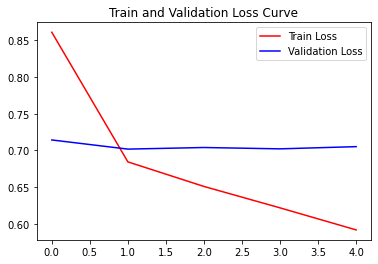

In [12]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.show()

In [13]:
#save the model
model.save('model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model/assets


In [15]:
# Extract embeddings
book_em = model.get_layer('embedding_4')
book_em_weights = book_em.get_weights()[0]
book_em_weights.shape

(10001, 15)

In [16]:
books_df_copy = books_df.copy()
books_df_copy = books_df_copy.set_index("book_id")
books_df_copy.head(2)

,id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
book_id,,,,,,,,,,,,,,,,,,,,,
2767052,1,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
3,2,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...


In [17]:

b_id =list(ratings_df.book_id.unique())
b_id.remove(10000)

In [18]:
b_id =list(ratings_df.book_id.unique())
b_id.remove(10000)
dict_map = {}
for i in b_id:
    dict_map[i] = books_df_copy.iloc[i]['title']
    
out_v = open('vecs.tsv', 'w')
out_m = open('meta.tsv', 'w')
for i in b_id:
    book = dict_map[i]
    embeddings = book_em_weights[i]
    out_m.write(book + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
    
out_v.close()
out_m.close()

In [19]:
#Making recommendations for user 100
book_arr = np.array(b_id) #get all book IDs
user = np.array([100 for i in range(len(b_id))])

pred = model.predict([book_arr, user])
pred

array([[3.9794333],
       [4.52411  ],
       [2.6925862],
       ...,
       [4.419017 ],
       [4.1501255],
       [3.4611099]], dtype=float32)

In [20]:
pred = pred.reshape(-1) #reshape to single dimension
pred_ids = (-pred).argsort()[0:5]
pred_ids

array([3627, 5206, 9565, 8977, 1787])

In [21]:
books_df.iloc[pred_ids]

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
3627,3628,24812,24812,25599,14,740748475,9.780741e+12,Bill Watterson,2005.0,The Complete Calvin and Hobbes,...,28900,29968,861,120,154,693,3117,25884,https://images.gr-assets.com/books/1473064526m...,https://images.gr-assets.com/books/1473064526s...
5206,5207,24818,24818,946589,28,836217357,9.780836e+12,Bill Watterson,1993.0,The Days Are Just Packed: A Calvin and Hobbes ...,...,19143,20374,228,114,149,942,3636,15533,https://images.gr-assets.com/books/1418211162m...,https://images.gr-assets.com/books/1418211162s...
9565,9566,70487,70487,2244439,24,1417642165,9.781418e+12,Bill Watterson,1992.0,Attack of the Deranged Mutant Killer Monster S...,...,9713,12197,233,15,30,514,2292,9346,https://images.gr-assets.com/books/1384735429m...,https://images.gr-assets.com/books/1384735429s...
8977,8978,121792,121792,1429035,20,1417642122,9.781418e+12,Bill Watterson,1991.0,The Revenge of the Baby-Sat: A Calvin and Hobb...,...,11503,12946,206,12,40,570,2428,9896,https://images.gr-assets.com/books/1384734025m...,https://images.gr-assets.com/books/1384734025s...
1787,1788,24813,24813,692719,17,836204387,9.780836e+12,Bill Watterson,1995.0,The Calvin and Hobbes Tenth Anniversary Book,...,48280,48829,346,346,608,3077,8752,36046,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...


In [22]:
web_book_data = books_df[["book_id", "title", "image_url", "authors"]]
web_book_data = web_book_data.sort_values('book_id')
web_book_data.head()

,book_id,title,image_url,authors
26,1,Harry Potter and the Half-Blood Prince (Harry ...,https://images.gr-assets.com/books/1361039191m...,"J.K. Rowling, Mary GrandPré"
20,2,Harry Potter and the Order of the Phoenix (Har...,https://images.gr-assets.com/books/1387141547m...,"J.K. Rowling, Mary GrandPré"
1,3,Harry Potter and the Sorcerer's Stone (Harry P...,https://images.gr-assets.com/books/1474154022m...,"J.K. Rowling, Mary GrandPré"
17,5,Harry Potter and the Prisoner of Azkaban (Harr...,https://images.gr-assets.com/books/1499277281m...,"J.K. Rowling, Mary GrandPré, Rufus Beck"
23,6,Harry Potter and the Goblet of Fire (Harry Pot...,https://images.gr-assets.com/books/1361482611m...,"J.K. Rowling, Mary GrandPré"


In [23]:
web_book_data.to_json(r'web_book_data.json', orient='records')